In [1]:
import torch
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

def all_activity(
    spikes: torch.Tensor, assignments: torch.Tensor, n_labels: int
) -> torch.Tensor:
    # language=rst
    """
    Classify data with the label with highest average spiking activity over all neurons.

    :param spikes: Binary tensor of shape ``(n_samples, time, n_neurons)`` of a layer's
        spiking activity.
    :param assignments: A vector of shape ``(n_neurons,)`` of neuron label assignments.
    :param n_labels: The number of target labels in the data.
    :return: Predictions tensor of shape ``(n_samples,)`` resulting from the "all
        activity" classification scheme.
    """
    n_samples = spikes.size(0)

    rates = torch.zeros((n_samples, n_labels), device=spikes.device)
    for i in range(n_labels):
        # Count the number of neurons with this label assignment.
        n_assigns = torch.sum(assignments == i).float()

        if n_assigns > 0:
            # Get indices of samples with this label.
            indices = torch.nonzero(assignments == i).view(-1)

            # Compute layer-wise firing rate for this label.
            rates[:, i] = torch.sum(spikes[:, indices], 1) / n_assigns

    # Predictions are arg-max of layer-wise firing rates.
    return torch.sort(rates, dim=1, descending=True)[1][:, 0]


def proportion_weighting(
    spikes: torch.Tensor,
    assignments: torch.Tensor,
    proportions: torch.Tensor,
    n_labels: int,
) -> torch.Tensor:
    # language=rst
    """
    Classify data with the label with highest average spiking activity over all neurons,
    weighted by class-wise proportion.

    :param spikes: Binary tensor of shape ``(n_samples, time, n_neurons)`` of a single
        layer's spiking activity.
    :param assignments: A vector of shape ``(n_neurons,)`` of neuron label assignments.
    :param proportions: A matrix of shape ``(n_neurons, n_labels)`` giving the per-class
        proportions of neuron spiking activity.
    :param n_labels: The number of target labels in the data.
    :return: Predictions tensor of shape ``(n_samples,)`` resulting from the "proportion
        weighting" classification scheme.
    """
    n_samples = spikes.size(0)

    rates = torch.zeros((n_samples, n_labels), device=spikes.device)
    for i in range(n_labels):
        # Count the number of neurons with this label assignment.
        n_assigns = torch.sum(assignments == i).float()

        if n_assigns > 0:
            # Get indices of samples with this label.
            indices = torch.nonzero(assignments == i).view(-1)

            # Compute layer-wise firing rate for this label.
            rates[:, i] += (
                torch.sum((proportions[:, i] * spikes)[:, indices], 1) / n_assigns
            )

    # Predictions are arg-max of layer-wise firing rates.
    predictions = torch.sort(rates, dim=1, descending=True)[1][:, 0]

    return predictions

def pop_prediction(
    spikes: torch.Tensor, label_profiles: torch.Tensor, n_labels: int
) -> torch.Tensor:
    # language=rst
    """
    Classify data with the label with highest aligned output activity profile.

    :param spikes: Binary tensor of shape ``(n_samples, time, n_neurons)`` of a layer's
        spiking activity.
    :param label_profiles: A vector of shape ``(n_neurons, n_labels)`` of neuron label assignments.
    :param n_labels: The number of target labels in the data.
    :return: Predictions tensor of shape ``(n_samples,)`` resulting from the "all
        activity" classification scheme.
    """

    #calculate align of each profile to the label profiles
    fits = torch.mm(spikes, label_profiles)

    # Predictions are arg-max of population activity vector products with label_profiles.
    return torch.sort(fits, dim=1, descending=True)[1][:, 0]

In [2]:
#recurrent nets

endpoint_delays = ["50", "100", "200"]

data = []
labels = []

test_data = []
test_labels = []

clf = []
label_profiles = []
assignments = []
proportions = []

#load everything
for i in range(1):
    data.append(torch.load(f'sdg_classification/norm_activities.pt').cpu().detach().numpy())
    labels.append(torch.load(f'sdg_classification/labelling.pt').cpu().detach().numpy())
    labels[i] = labels[i].reshape((2230))
    
    test_data.append(torch.load(f'sdg_classification/test_norm_activities.pt').cpu().detach().numpy())
    test_labels.append(torch.load(f'sdg_classification/test_labelling.pt').cpu().detach().numpy())
    
    clf.append(make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, loss='modified_huber')))
    clf[i].fit(data[i], labels[i])
    
    label_profiles.append(torch.load(f'label_profiles/final_profiles.pt').cpu().detach().numpy())
    
    assignments.append(torch.load(f'neuron_eval/final_assignments_at_100%.pt').cpu().detach().numpy())
    proportions.append(torch.load(f'neuron_eval/final_proportions_at_100%.pt').cpu().detach().numpy())
    
#predict stuff train
train_correct = []
train_pred_svm = []
train_pred_pop = []
train_pred_all = []
train_pred_prop = []

counter = 0

for i in range(1):
    
    train_correct.append([0,0,0,0])
    train_pred_svm.append(clf[i].predict(data[i]))
    data_tensor = torch.from_numpy(data[i])
    label_profiles_tensor = torch.from_numpy(label_profiles[i])
    assignments_tensor = torch.from_numpy(assignments[i])
    proportions_tensor = torch.from_numpy(proportions[i])

    train_pred_pop.append(pop_prediction(data_tensor, label_profiles_tensor, 10))
    train_pred_all.append(all_activity(data_tensor, assignments_tensor, 10))
    train_pred_prop.append(proportion_weighting(data_tensor, assignments_tensor, proportions_tensor, 10))
    
    counter = 0
    
    for label in labels[i]:    
        if(train_pred_svm[i][counter] == label): train_correct[i][0] += 1
        if(train_pred_pop[i][counter] == label): train_correct[i][1] += 1
        if(train_pred_all[i][counter] == label): train_correct[i][2] += 1
        if(train_pred_prop[i][counter] == label): train_correct[i][3] += 1
        
        counter+=1
        
        
n_train = counter + 1
        
#predict stuff test
test_correct = []
test_pred_svm = []
test_pred_pop = []
test_pred_all = []
test_pred_prop= []

counter = 0

for i in range(1):
    
    test_correct.append([0,0,0,0])
    test_pred_svm.append(clf[i].predict(test_data[i]))
    test_data_tensor = torch.from_numpy(test_data[i])
    label_profiles_tensor = torch.from_numpy(label_profiles[i])
    assignments_tensor = torch.from_numpy(assignments[i])
    proportions_tensor = torch.from_numpy(proportions[i])
    
    test_pred_pop.append(pop_prediction(test_data_tensor, label_profiles_tensor, 10))
    test_pred_all.append(all_activity(test_data_tensor, assignments_tensor, 10))
    test_pred_prop.append(proportion_weighting(test_data_tensor, assignments_tensor, proportions_tensor, 10))
    
    counter = 0
    
    for label in test_labels[i]:
        if(test_pred_svm[i][counter] == label): test_correct[i][0] += 1
        if(test_pred_pop[i][counter] == label): test_correct[i][1] += 1
        if(test_pred_all[i][counter] == label): test_correct[i][2] += 1
        if(test_pred_prop[i][counter] == label): test_correct[i][3] += 1
        
        counter += 1
        
n_test = counter + 1

#convert to accuracies
svm_acc = [[],[]]
pop_acc = [[],[]]
all_acc = [[],[]]
prop_acc = [[],[]]

for i in range(1):
    svm_acc[0].append(train_correct[i][0]/n_train)
    svm_acc[1].append(test_correct[i][0]/n_test)
    pop_acc[0].append(train_correct[i][1]/n_train)
    pop_acc[1].append(test_correct[i][1]/n_test)
    all_acc[0].append(train_correct[i][2]/n_train)
    all_acc[1].append(test_correct[i][2]/n_test)
    prop_acc[0].append(train_correct[i][3]/n_train)
    prop_acc[1].append(test_correct[i][3]/n_test)

In [4]:
svm_acc

[[0.575974899148364], [0.32684652808491815]]

In [5]:
pop_acc

[[0.4069923800986105], [0.33171163202122955]]

In [6]:
all_acc

[[0.42088749439713136], [0.2998673153471915]]

In [7]:
prop_acc

[[0.4625728372926939], [0.32596196373286157]]

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (3).

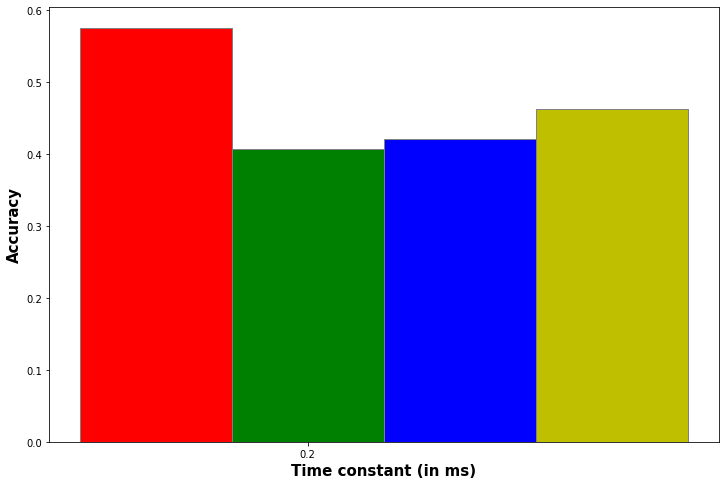

In [3]:
#plot train
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(svm_acc[0]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, svm_acc[0], color ='r', width = barWidth,
        edgecolor ='grey', label ='SVM')
plt.bar(br2, pop_acc[0], color ='g', width = barWidth,
        edgecolor ='grey', label ='Population')
plt.bar(br3, all_acc[0], color ='b', width = barWidth,
        edgecolor ='grey', label ='All accuracy')
plt.bar(br4, prop_acc[0], color ='y', width = barWidth,
        edgecolor ='grey', label ='Proportion')
 
# Adding Xticks
plt.xlabel('Time constant (in ms)', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(1)],
        endpoint_delays)
plt.yticks(np.arange(0, 1.1, step=0.1))
#plt.title("(a)", fontsize=30)
 
plt.legend()

plt.savefig("Accuracy values on training dataset for recurrents.png", dpi=300)

In [ ]:
#plot test
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8))

# Set position of bar on X axis
br1 = np.arange(len(svm_acc[1]))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]
 
# Make the plot
plt.bar(br1, svm_acc[1], color ='r', width = barWidth,
        edgecolor ='grey', label ='SVM')
plt.bar(br2, pop_acc[1], color ='g', width = barWidth,
        edgecolor ='grey', label ='Population')
plt.bar(br3, all_acc[1], color ='b', width = barWidth,
        edgecolor ='grey', label ='All accuracy')
plt.bar(br4, prop_acc[1], color ='y', width = barWidth,
        edgecolor ='grey', label ='Proportion')
 
# Adding Xticks
plt.xlabel('Time constant (in ms)', fontweight ='bold', fontsize = 15)
plt.ylabel('Accuracy', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(1)],
        endpoint_delays)
plt.yticks(np.arange(0, 1.1, step=0.1))
#plt.title("(a)", fontsize=30)
 
plt.legend()

plt.savefig("Accuracy values on test dataset for recurrents.png", dpi=300)